### ISC CamCan Suspense

This notebook implements the sliding-window ISC analysis on the CamCan data.

### setting up modules

In [1]:
import os, sys, scipy, nilearn, warnings
warnings.filterwarnings("ignore")
import numpy as np
from nilearn import plotting, input_data
from nilearn.input_data import NiftiLabelsMasker
import seaborn as sns
import pandas as pd
from scipy import stats

import matplotlib.pyplot as plt
%matplotlib inline

from camcan_utils import *

/Users/Ralf/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


### set up files

In [2]:
suspense_file         = '../data/avg_suspense.npy'
dict_file             = '../data/timeseries_dictionary.npy'
ts_data_file          = '../data/ts_data.npy'
shen_dictionary_file  = '../data/shen_dictionary.npy'
shen_atlas_filename   = '../data/shen_2mm_268_parcellation.nii'
sample_file           = '../data/func.nii'
dyn_isc_file          = '../data/dyn_isc_dict.npy'


### load data 
see description in notebook on main ISC analysis

In [3]:
ts_data = np.load(ts_data_file)
n_tr, n_regions, n_subjs = ts_data.shape
n_regions

268

### compute dynamic ISC analysis

In [4]:
''' 
### compute main sliding window analysis across full data (takes a while - hence precomputed)
dyn_isc_result_all = camcan_sliding_isc(ts_data[:,:,:])

#### set up two sub-samples (for consistency check)
subject_chunks = [[0, int(n_subjs/2)],
                  [int(n_subjs/2), n_subjs]]

n_iterations = len(subject_chunks)

dyn_isc_result = np.zeros((n_iterations, n_tr, n_regions))

sub_index = np.arange(n_subjs)
np.random.shuffle(sub_index)

for curr_sample in range(n_iterations): 
    print('Working on subgroup #', (curr_sample +1 ), ' of ', n_iterations)
    people_to_use = np.arange(subject_chunks[curr_sample][0], subject_chunks[curr_sample][1], 1)

    D = ts_data[:,:,sub_index[people_to_use] ]
    dyn_isc_result[curr_sample, :, :] = camcan_sliding_isc(D)

### save results - because computing them every time from scratch takes a lot of time 
### we save the output here so we can load it quicker later on

dyn_isc_dict = {}
dyn_isc_dict['dyn_isc_result_all'] = dyn_isc_result_all
dyn_isc_dict['dyn_isc_result_splithalf'] = dyn_isc_result

np.save('../data/dyn_isc_dict.npy', dyn_isc_dict) 

np.corrcoef( scipy.stats.zscore(np.nanmean(dyn_isc_result[0,:,:], axis = 1)), 
             scipy.stats.zscore(np.nanmean(dyn_isc_result[1,:,:], axis = 1)) )[0,1]

#'''

# if precomputed
dyn_isc_dict       = np.load(dyn_isc_file, allow_pickle=True).item() 
dyn_isc_dict.keys()
dyn_isc_result_all = dyn_isc_dict['dyn_isc_result_all']       #this is the result across the full sample
dyn_isc_result     = dyn_isc_dict['dyn_isc_result_splithalf'] #this is the result for one random group split


### plot dynISC: Whole brain (Figure 3A)

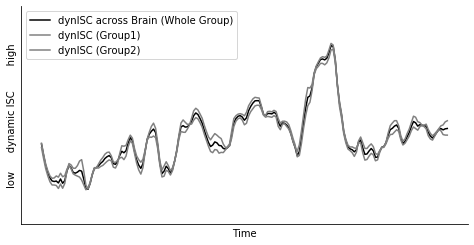

In [5]:
f = plt.figure(figsize=(8,4))
ax1 = f.add_subplot(111)
ax1.plot(scipy.stats.zscore(np.nanmean(dyn_isc_result_all[:,:], axis = 1)), color = 'black', label = 'dynISC across Brain (Whole Group)');
ax1.plot(scipy.stats.zscore(np.nanmean(dyn_isc_result[0,:,:],   axis = 1)), color = 'gray',  label = 'dynISC (Group1)');
ax1.plot(scipy.stats.zscore(np.nanmean(dyn_isc_result[1,:,:],   axis = 1)), color = 'gray',  label = 'dynISC (Group2)');
plt.legend(loc = 2)
plt.xlabel('Time')
plt.ylabel('low      dynamic ISC        high')
plt.ylim(-3, 4.5)
plt.xticks([]);
plt.yticks([]);
sns.despine()

In [6]:
#reviewer wants exact p
from scipy.stats import linregress
linregress(
            scipy.stats.zscore(np.nanmean(dyn_isc_result[0,:,:],   axis = 1)),
            scipy.stats.zscore(np.nanmean(dyn_isc_result[1,:,:],   axis = 1))
          )[2:4]


(0.9633416949091296, 4.32982269576304e-111)

### plot dynISC: aMCC (Figure 3B)

84.44% Cingulate_Gyrus_anterior_division; 11.00% Left_Lateral_Ventrical


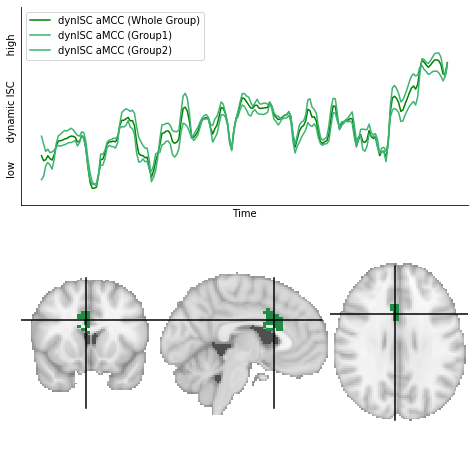

In [7]:
curr_region = 220 #aMCC
shen_dictionary = np.load(shen_dictionary_file, allow_pickle=True).item()
curr_title = shen_dictionary[curr_region + 1]['name'] 

region_vector = np.zeros((1,268))
region_vector[0,curr_region] = 0.5
shen_masker = NiftiLabelsMasker(labels_img=shen_atlas_filename);
shen_masker.fit_transform(sample_file);
region_img = shen_masker.inverse_transform(region_vector);

print(curr_title)
curr_coords = shen_dictionary[curr_region + 1]['coords'] 

f = plt.figure(figsize=(8,8))
ax1 = f.add_subplot(211)
ax1.plot(scipy.stats.zscore(dyn_isc_result_all[:,curr_region]), color = 'green',          label = 'dynISC aMCC (Whole Group)');
ax1.plot(scipy.stats.zscore(dyn_isc_result[0,:,curr_region]),   color = 'mediumseagreen', label = 'dynISC aMCC (Group1)');
ax1.plot(scipy.stats.zscore(dyn_isc_result[1,:,curr_region]),   color = 'mediumseagreen', label = 'dynISC aMCC (Group2)');
plt.legend(loc = 2)
plt.xlabel('Time')
plt.ylabel('low      dynamic ISC        high')
plt.ylim(-3, 4.5)
plt.xticks([]);
plt.yticks([]);
sns.despine()

ax2 = f.add_subplot(212)    
nilearn.plotting.plot_stat_map(nilearn.image.index_img(region_img,0),threshold = 0.45, vmax = 1., draw_cross = True,colorbar = False,
                                       cmap = 'Greens',  annotate = False,cut_coords = curr_coords,
                                       axes = ax2);


In [8]:
curr_region = 220 #aMCC

linregress(
            scipy.stats.zscore(dyn_isc_result[0,:,curr_region]),
            scipy.stats.zscore(dyn_isc_result[1,:,curr_region])
          )[2:4]

(0.8587272706342103, 2.327392497177621e-57)